# Декораторы

## Немного вспомним про функции

Мы с вами уже знаем, что в питоне любая **функция** это **объект**. Функции можно записывать в переменные и передавать в другие функции. Такие функции (в которые мы передаём другие функции) называются **фукциями высшего порядка**.

Мы с ними уже хорошо знакомы, например: `map`, `filter`, `partial` и др

In [5]:
def inc(a):
    return a + 1


for i in map(inc, [1, 2, 3, 4, 5]):   # Мы передали функцию inc как аргумент функции map
    print(i)

2
3
4
5
6


## Формулируем проблему

Как же с этим связаны декораторы, что они такое и зачем они нужны? Давайте сформулируем проблему на игрушечном примере.

Допустим, что у нас есть много функций, которые выполняют какую-то работу

In [6]:
import random


def small_work():
    for _ in range(10000):
        random.uniform(0, 1000) ** random.uniform(0, 5)
        
def medium_work():
    for _ in range(100000):
        random.uniform(0, 1000) ** random.uniform(0, 5)
        
def big_work():
    for _ in range(1000000):
        random.uniform(0, 1000) ** random.uniform(0, 5)

Мы хотим замерить время выполнения этих функций

Для справки `time.time()` возвращает [UNIX время](https://en.wikipedia.org/wiki/Unix_time) в секундах, само по себе это значение бесполезно, но мы можем использовать разность двух значений для измерения длительности чего-то. Вообще, для измерения времени работы чего-либо, стоит использовать `time.perf_counter()`, но мне кажется, что `time.time()` проще запомнить

In [7]:
import time


start = time.time()
small_work()
end = time.time()
print(f"Function small_work has finished in {end - start} second")

start = time.time()
medium_work()
end = time.time()
print(f"Function medium_work has finished in {end - start} second")

start = time.time()
big_work()
end = time.time()
print(f"Function big_work has finished in {end - start} second")

Function small_work has finished in 0.003958702087402344 second
Function medium_work has finished in 0.02940082550048828 second
Function big_work has finished in 0.2720625400543213 second


Это не самый удобный способ, нам 3 раза пришлось написать один и тот же код, это точно можно упростить. Посмотрим на вариант ниже

In [8]:
for function in [small_work, medium_work, big_work]:
    start = time.time()
    function()
    end = time.time()
    print(f"Function {function.__name__} has finished in {end - start} second")

Function small_work has finished in 0.0025680065155029297 second
Function medium_work has finished in 0.02717447280883789 second
Function big_work has finished in 0.2744448184967041 second


Уже лучше, мы сделали цикл по функциям, но этот способ будет очень неудобен, если наши функции будут принимать какие-то аргументы. В таком случае нам пришлось бы как-то отдельно хранить аргументы для функций, отдельно итерироватся по ним и т.д., короче сложно

## Базовый синтаксис декораторов

Для того, чтобы избежать всех этих проблем напишем вот такую конструкцию

In [9]:
def measure_time(func):
    def inner_function():
        start = time.time()
        func()
        end = time.time()
        print(f"Function {func.__name__} has finished in {end - start} seconds")
    return inner_function

In [10]:
small_work = measure_time(small_work)
medium_work = measure_time(medium_work)
big_work = measure_time(big_work)

small_work()
medium_work()
big_work()

Function small_work has finished in 0.002588033676147461 second
Function medium_work has finished in 0.0268404483795166 second
Function big_work has finished in 0.2687263488769531 second


Давайте разберём, что здесь произошло. Мы создали функцию `measure_time`, которая принимает на вход любую другую функцию, мы будем передавать в неё наши фунции `xxxx_work`, Внутри `measure_time` мы через `def` объявляем новую функцию `inner_function`, которую затем возвращаем. Обратите внимание, что внутри `measure_time` мы **НЕ вызываем** `inner_function`, а просто **возвращаем её как объект**. После возвращения из `measure_time` функция `inner_function` запишется в переменную `small_work` вот в этой строке
```python
small_work = measure_time(small_work)
```
Пока мы не разбирали, что происходит в `inner_function`, нам было важно лишь то, что её объявили внутри функции `measure_time` и вернули из неё.

Но всё-таки интересно, что там произошло. Ведь этой самой функцией мы по сути подменяем наши оригинальные (как в примере выше). Давайте разбираться

Внутри `inner_function` происходит знакомый нам расчёт времени выполнения функции `func`, которая изначально была передана в `measure_time`. По сути сам вызов функции не изменятся, он только "оборачивается" в дополнительный функционал вычисления времени выполнения (или иначе говоря, **"декорируется"**) и запаковывается в новую функцию `inner_function`, которая возвращается нам.

Функция `measure_time` является **декоратором**, а `func` **декорируемой** функцией. Проще говоря, декораторы просто "оборачивают" наши функции в дополнительный функционал, без изменений их кода и логики работы. Т.е. `func` отрабатывает без каких-либо изменений, но добавляется дополнительный код до и после её вызова.

На картинке обозначены основные элементы декоратора
![image.png](attachment:5bdbcd94-b581-4650-8b78-ff7b8097fae9.png)

Пример выше демонстрирует основной синтаксис декораторов в питоне и да, это выглядит страшно :)

## Декорируем функции, принимающие аргументы

Мы можем сделать ещё одно улучшение и добавить возможность принимать функции с любыми аргументами, а также возвращать значение, так как в примере выше мы имеем самый простой вариант - ничего не возвращающую функцию без аргументов

In [11]:
def measure_time(func):
    def inner_function(*args, **kwargs):
        start = time.time()
        result = func(*args, **kwargs)
        end = time.time()
        print(f"Function {func.__name__} has finished in {end - start} second")
        return result
    return inner_function

Теперь функция возвращаемая из декоратора (`inner_function`) будет принимать любое количество позиционных и именованных аргументов, которые затем будут просто "пробрасываться" в внутренний вызов `func`

Результат выполнения нашей декорируемой функции мы сохранили в переменную `result` и возвращаем её в самом конце. Мы не можем сразу написать `return func(*args, **kwargs)`, так как у нас есть действия, которые мы ходим выполнить **после** вызова декорируемой функции. Сохранить результат её выполнения в переменную и вернуть в самом конце - стандартная практика

Убедимся, что всё работает на примерах

In [12]:
def add(a, b):
    return a + b

def square_list(lst):
    return [i**2 for i in lst]

def invert_dictionary(dct):
    return dict(zip(dct.values(), dct.keys()))

def repeat_string(string, n_repeats=2):
    return string * n_repeats

In [13]:
add = measure_time(add)
square_list = measure_time(square_list)
invert_dictionary = measure_time(invert_dictionary)
repeat_string = measure_time(repeat_string)


print(add(10012401204, 3893475983475), end="\n\n")
print(square_list(list(range(25))), end="\n\n")
print(invert_dictionary({"a": 1, "b": 2, "c": 3, "d": 4}), end="\n\n")
print(repeat_string("ABCDEFG*", n_repeats=10))

Function add has finished in 1.430511474609375e-06 second
3903488384679

Function square_list has finished in 8.58306884765625e-06 second
[0, 1, 4, 9, 16, 25, 36, 49, 64, 81, 100, 121, 144, 169, 196, 225, 256, 289, 324, 361, 400, 441, 484, 529, 576]

Function invert_dictionary has finished in 3.337860107421875e-06 second
{1: 'a', 2: 'b', 3: 'c', 4: 'd'}

Function repeat_string has finished in 1.1920928955078125e-06 second
ABCDEFG*ABCDEFG*ABCDEFG*ABCDEFG*ABCDEFG*ABCDEFG*ABCDEFG*ABCDEFG*ABCDEFG*ABCDEFG*


## Делаем запись более удобной

Всё работает! Функции выполняют свои обычные операции и при этом пишут сообщения о времени выполнения. Заметим только, что нам всё равно приходится вручную декорировать наши функции вот такой неудобной записью, передавая каждую как аргумент декоратору
```python
add = measure_time(add)
square_list = measure_time(square_list)
invert_dictionary = measure_time(invert_dictionary)
repeat_string = measure_time(repeat_string)
```
Это исправимо, в питоне для этого есть специальный очень удобный синтаксис. При объявлении функций мы как бы помечаем их следующим образом

In [14]:
@measure_time
def add(a, b):
    return a + b

@measure_time
def square_list(lst):
    return [i**2 for i in lst]

@measure_time
def invert_dictionary(dct):
    return dict(zip(dct.values(), dct.keys()))

@measure_time
def repeat_string(string, n_repeats=2):
    return string * n_repeats


print(add(10012401204, 3893475983475), end="\n\n")
print(square_list(list(range(25))), end="\n\n")
print(invert_dictionary({"a": 1, "b": 2, "c": 3, "d": 4}), end="\n\n")
print(repeat_string("ABCDEFG*", n_repeats=10))

Function add has finished in 7.152557373046875e-07 second
3903488384679

Function square_list has finished in 8.821487426757812e-06 second
[0, 1, 4, 9, 16, 25, 36, 49, 64, 81, 100, 121, 144, 169, 196, 225, 256, 289, 324, 361, 400, 441, 484, 529, 576]

Function invert_dictionary has finished in 2.86102294921875e-06 second
{1: 'a', 2: 'b', 3: 'c', 4: 'd'}

Function repeat_string has finished in 1.6689300537109375e-06 second
ABCDEFG*ABCDEFG*ABCDEFG*ABCDEFG*ABCDEFG*ABCDEFG*ABCDEFG*ABCDEFG*ABCDEFG*ABCDEFG*


Всё работает точно также, но синтаксис стал намного красивее. Теперь мы можем "повесить" `@measure_time` на любую функцию в нашей программе и она будет способна измерять время своего исполнения.

Как вы уже поняли записи
```python
@measure_time
def add(a, b):
    ...
```
и
```python
add = measure_time(add)
```
абсолютно равнозначны


## Декораторы с параметрами

А что если мы захотим как-то управлять поведением декоратора, например, передавать ему какие-то параметры? Для демонстрации мы попытаемся написать декоратор, который заставит функцию выполняться, пока та не отработает без ошибок, причём мы сможем задать количество попыток запустить функцию

Но для начала напишем такую функцию

In [15]:
def problematic_function(probability_of_error):
    if random.random() < probability_of_error:
        raise RuntimeError
    else:
        return "Success"

Функция принимает один аргумент - вероятность ошибки и кидает ошибку с данной вероятностью. Наша задача написать декоратор, который заставит её выполняться определённое число попыток или же до успешного исполнения.

Без декоратора это выглядело бы примерно так

In [21]:
n_tries = 5
for _ in range(n_tries):
    try:
        print(problematic_function(0.9))
        break
    except RuntimeError:
        continue
else:   # Если мы не вышли из цикла досрочно (через break), то кидаем ошибку, так как это значит, что все попытки провалились
    raise RuntimeError

Success


Давайте напишем декоратор, который будет принимать число попыток (`n_tries`) в качестве аргумента, но ещё добавим возможность исполнения до успеха.

Попробуйте осознать этот код

In [22]:
def try_n_times(func, n_tries=None):
    def inner_func(*args, **kwargs):
        try_num = 0
        while try_num != n_tries:  # Если n_tries это None, то у нас будет вечный цикл пока функция успешно не выполнится
            try:
                return func(*args, **kwargs)
            except RuntimeError:
                try_num += 1
                continue
        else:
            raise RuntimeError
    return inner_func

Теперь задекорируем функцию, передав в декоратор аргумент `n_tries`

In [23]:
@try_n_times(n_tries=5)
def problematic_function(probability_of_error):
    if random.random() < probability_of_error:
        raise RuntimeError
    else:
        return "Success"

TypeError: try_n_times() missing 1 required positional argument: 'func'

Не работает, давайте теперь попробуем стандартный синтаксис декорирования

In [112]:
problematic_function = try_n_times(problematic_function, n_tries=5)

In [115]:
problematic_function(0.9)

'Success'

На этот раз всё работает. Дело в том, что синтаксис `@` ожидает, что декоратор будет принимать всего один аргумент - **декорируемую функцию**, поэтому мы не можем передать никакие параметры. Однако, мы очень часто видим, что декораторы в различных библиотеках могут принимать параметры, вот пример из фреймворка *Flask*

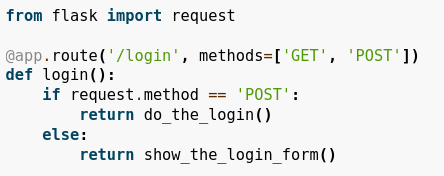

Как же это работает? Давайте разберём, здесь всё будет довольно запутанно...

In [24]:
def try_n_times(n_tries=None):
    def decorator(func):
        def inner_func(*args, **kwargs):
            try_num = 0
            while try_num != n_tries:
                try:
                    return func(*args, **kwargs)
                except RuntimeError:
                    try_num += 1
                    continue
            else:
                raise RuntimeError
        return inner_func
    return decorator

In [118]:
@try_n_times(n_tries=5)
def problematic_function(probability_of_error):
    if random.random() < probability_of_error:
        raise RuntimeError
    else:
        return "Success"

In [135]:
problematic_function(0.9)

'Success'

В этот раз всё работает, разберём код

По сути здесь не произошло принципиальных изменений, мы лишь обернули наш декоратор ещё в одну функцию, но зачем?

Во-первых, стоит заметить, что то, что было декоратором в предыдущем примере (функция `decorator`) теперь принимает всего один аргумент - **декорируемую функцию**, т.е. мы удовлетворили данному условию использования `@`.

Во-вторых, у нас появилась новая функция - `try_n_times`. Обратите внимание на то, что она не является декоратором, так как не принимает на вход другую функцию, она принимает только параметр `n_tries`. Но зачем же она нужна? Последняя строка этой функции говорит сама за себя, она **возвращает декоратор**. Причём этот декоратор имеет заданные свойства, так как сохраняет в себе данные о количестве попыток, которые нужно произвести (`n_tries`)

Так что же на самом деле произошло здесь?
```python
@try_n_times(n_tries=5)
def problematic_function(probability_of_error):
```
Мы уже знаем, что `try_n_times` не является декоратором, но она **возвращает декоратор**, который будет пытаться выполнить функцию 5 раз. Т.е. запись выше в процессе выполнения раскрывается в нечто подобное
```python
decorator = try_n_times(n_tries=5)
@decorator
def problematic_function(probability_of_error):
```

То есть `try_n_times` это такой завод по производству декораторов, так можно создавать самые разные декораторы просто указывая различные аргументы

In [25]:
infinite_decorator = try_n_times(n_tries=None)
single_attempt_decorator = try_n_times(n_tries=1)
six_attempts_decorator = try_n_times(n_tries=6)

## Замыкания

Вы уже заметили, что при использовании декораторов мы постоянно используем переменные из более внешних областей видимости во вложенных функциях. Например, параметр `n_tries` в примере выше. Декорируемая функция тоже не является исключением, так как мы используем её в более вложенных. Но это работает не только с декораторами. Рассмотрим вот такой пример...

In [156]:
a = 5

def wrapper(a):
    def func():
        return a
    return func
    
func = wrapper(a)

Мы вызываем функцию `wrapper` с одним аргументом, которая отдаёт нам функцию `func`, "запомнившую" этот аргумент и возвращающую его. Убедимся, что это работает.

In [157]:
func()

5

Здесь также важно заметить, что `func` "запоминает" НЕ переменную `a` из глобальной области видимости, а переменную `a` из локального окружения функции `wrapper`. Убедимся в этом, удалив глобальную переменную `a`

In [158]:
del a
func()

5

Функция по прежнему работает, хотя переменная была удалена, значит, что она её "запомнила". Ещё раз убедимся в этом, явно указав функции `func`, что нужно использовать глобальную переменную. После удаления переменной и вызова функции мы получим ошибку

In [160]:
a = 5

def wrapper(a):
    def func():
        global a
        return a
    return func
    
func = wrapper(a)
del a
func()

NameError: name 'a' is not defined

Такой механиханизм "запоминания" называется **замыканием (closure)**.

В питоне есть сборщик мусора, которые удаляет все объекты на которые не осталось ссылок. Команда `del` как раз таки удаляет эти ссылки (не объекты). Получается, что в замыкании создаются новые ссылки, так как функция спокойно работает после удаления внешней переменной. А если есть новые ссылки, получается, что эти данные можно как-то достать

In [164]:
a = 5
b = [1, 2, 3]
c = {1: 2, "a": "b"}

def wrapper(a, b, c):
    def func():
        return a, b, c
    return func
    
func = wrapper(a, b, c)

Ради интереса мы положили в замыкание чуть больше разных объектов. До списка этих объектов можно достучаться через атрибут `__closure__` у функции, но я не знаю где вам это может пригодиться :)

In [169]:
for element_idx in range(3):
    print(func.__closure__[element_idx].cell_contents)

5
[1, 2, 3]
{1: 2, 'a': 'b'}


# Полезные декораторы

В этом разделе мы поговорим о библиотечных и встроенных декораторах, которые довольно полезны и рекомендуются к применению. Для удобства полный список с ссылками приведён ниже:

+ [classmethod и staticmethod](https://webdevblog.ru/obyasnenie-classmethod-i-staticmethod-v-python/) - используются постоянно, если вы работаете с ООП - знать и использовать нужно обязательно (встроенные в питон, импортировать не нужно)
+ [functools.lru_cache](https://docs-python.ru/standart-library/modul-functools-python/dekorator-lru-cache-modulja-functools/)
+ [dataclass](https://habr.com/ru/post/415829/)
+ [property](https://www.programiz.com/python-programming/property) - также часто появляется в объектно-ориентированном коде (встроен в питон)
+ [wraps](https://stackoverflow.com/questions/308999/what-does-functools-wraps-do)

## `classmethod`

Декоратор `classmethod` необходим для того, чтобы сделать метод классовым

Допустим, что у нас есть класс, представляющий структуру данных похожую на словарь и мы хотим уметь создавать её разными способами. Для этого у нас есть отдельные методы, возвращающие экземпляр этого же класса. Создание экщемпляров класса через методы это очень часто используемая практика.

In [1]:
class MyCustomMap:
    def __init__(self, dct=None):
        self.__map = dct
        
    def from_dict(self, dct):
        return MyCustomMap(dct)
    
    def from_lists(self, list1, list2):
        return MyCustomMap(dict(zip(list1, list2)))
    
    def from_strings(self, str1, str2):
        return type(self)(dict(zip(str1, str2)))
    
    def __repr__(self):
        return f"My custom map {self.__map}"

Очевидно, что данные методы используются только для создания объектов. Они никак не взаимодействуют с данными, хранящимися в атрибутах экземпляров класса (в коде этих методов мы не видим никакого использования `self`), а значит им вовсе необязательно быть связанными с экземплярами. К тому же вызывать их мы сможем только от экземпляров, что не очень удобно.

In [2]:
MyCustomMap.from_strings("ABCD", "EFGH")   # Пытаемся вызывать метод from_strings от класса. Ничего не получается, так как метод ожидает объект данного класса (self) в качестве первого аргумента

TypeError: from_strings() missing 1 required positional argument: 'str2'

In [3]:
MyCustomMap().from_strings("ABCD", "EFGH")   # Получилось, но мы бы не хотели создавать экземпляр MyCustomMap()

My custom map {'A': 'E', 'B': 'F', 'C': 'G', 'D': 'H'}

Мы хотим, чтобы было как в пандасе с созданием датафрейма, примеры ниже

In [197]:
import pandas as pd


pd.DataFrame.from_dict({"Column1": [1, 2]})

,Column1
0,1
1,2


In [198]:
pd.DataFrame.from_records([("A", "1"), ("B", 2)])

,0,1
0,A,1
1,B,2


Здесь методы `from_dict` и `from_records` являются **методами класса** `DataFrame` и для их вызова не обязательно иметь объект класса DataFrame. Сделаем также с нашими методами.

In [13]:
class MyCustomMap:
    def __init__(self, dct=None):
        self.__map = dct
    
    @classmethod
    def from_dict(cls, dct):
        return cls(dct)
    
    @classmethod
    def from_lists(cls, list1, list2):
        return cls(dict(zip(list1, list2)))

    @classmethod
    def from_strings(cls, str1, str2):
        return cls(dict(zip(str1, str2)))
    
    def __repr__(self):
        return f"My custom map {self.__map}"
    

def from_dict(dct):
    return dct

In [14]:
MyCustomMap.from_strings("ABCD", "EFGH")

My custom map {'A': 'E', 'B': 'F', 'C': 'G', 'D': 'H'}

Всё отлично работает, мы всего лишь указали декоратор `classmethod` для методов, которые мы хотели сделать классовыми.

❗Обратите внимание, что методы класса ведут себя немного по другому. Первым аргументом к ним попадает **не экземпляр** данного класса, а **сам класс**, поэтому первый аргумент у методов класса принято называть `cls` вместо `self` (cls - сокращение от **cl**as**s**). Используя эту особенность, мы также смогли избавиться от явного указания класса, экземпляр которого мы хотим создать. В нашей ситуации `cls` во всех методах это `MyCustomMap`.

При этом всём классовый метод можно вызвать и от экземпляра, ничего не поломается.

In [29]:
MyCustomMap().from_strings("ABCD", "EFGH")

My custom map {'A': 'E', 'B': 'F', 'C': 'G', 'D': 'H'}

## `staticmethod`

Сделаем класс, собирающий информацию о загрузке и температуре процессора в течение времени, детально в коде можно не разбираться.

In [30]:
import psutil
from datetime import datetime


class CPUMonitor:
    def __init__(self):
        self._times = []
        self._loads = []
        self._temps = []
        
    def record(self, seconds):
        start_time = datetime.now()
        print("Recording started...")
        while True:
            self._times.append(datetime.now())
            cpu_load = self.get_cpu_load()
            self._loads.append(cpu_load)
            cpu_temp = self.get_cpu_temperature()
            self._temps.append(cpu_temp)
            print(f"\rRecording in progress... Current CPU load: {cpu_load}%, Current CPU temperature: {cpu_temp}", end="")
            if (self._times[-1] - start_time).total_seconds() > seconds:
                print("\nRecording stopped")
                break
                
    def reset(self):
        self._times = []
        self._loads = []
        self._temps = []
        
    def get_cpu_temperature(self):
        tdie = psutil.sensors_temperatures()["k10temp"][1].current
        return tdie
    
    def get_cpu_load(self):
        load_percent = psutil.cpu_percent()
        return load_percent

In [31]:
monitor = CPUMonitor()
monitor.record(5)

Recording started...
Recording in progress... Current CPU load: 2.2%, Current CPU temperature: 31.255
Recording stopped


Но нас интересует не столько сам класс, сколько методы `get_cpu_temperature` и `get_cpu_load`, что же в них необычного?

Давайте посмотрим на них внимательно. Оба метода в данный момент связаны с экземпляром класса, но никак это не используют (`self` в их коде не упоминается). Логично тогда предположить, что из этих методов можно сделать методы класса при помощи декоратора о котором мы говорили раньше. В таком случае методы будут связаны с классом. Однако в таком случае они опять никак не будут использовать эту связь.

Получается так, что эти методы вообще могут не иметь никакой связи с классом и его экземплярами и, видимо, просто стоило сделать из них отдельные функции... Или всё таки нет...?

Дело в том, что эти методы действительно не связаны с экземплярами класса какими-то общими данными, однако **по смыслу** функционал методов прекрасно интегрируется в класс. Т.е. нахождение методов для получения параметров процессора в классе для мониторинга этих параметров это очень уместное решение. Если бы эти методы на самом деле были отдельными функциями, то нам не удалось бы красиво инкапсулировать всё в один класс. Они связаны с классом **по смыслу**, поэтому их всё же стоит оставить в классе

Специально для таких методов в питоне есть декоратор `staticmethod`, он позволяет превращать методы в **статические**

In [32]:
class CPUMonitor:
    def __init__(self):
        self._times = []
        self._loads = []
        self._temps = []
        
    def record(self, seconds):
        start_time = datetime.now()
        print("Recording started...")
        while True:
            self._times.append(datetime.now())
            cpu_load = self.get_cpu_load()
            self._loads.append(cpu_load)
            cpu_temp = self.get_cpu_temperature()
            self._temps.append(cpu_temp)
            print(f"\rRecording in progress... Current CPU load: {cpu_load}, Current CPU temperature: {cpu_temp}", end="")
            if (self._times[-1] - start_time).total_seconds() > seconds:
                print("\nRecording stopped")
                break
                
    def reset(self):
        self._times = []
        self._loads = []
        self._temps = []
    
    @staticmethod
    def get_cpu_temperature(format_=False):   # Мы убрали self, так как связи с объектом нет и он больше не нужен и добавили новый аргумент
        tdie = psutil.sensors_temperatures()["k10temp"][1].current
        if format_:
            tdie = str(tdie) + "°C"
        return tdie
    
    @staticmethod
    def get_cpu_load(format_=False):   # Мы убрали self, так как связи с объектом нет и он больше не нужен и добавили новый аргумент
        load_percent = psutil.cpu_percent()
        if format_:
            load_percent = str(load_percent) + "%"
        return load_percent

In [33]:
monitor = CPUMonitor()
monitor.record(5)

Recording started...
Recording in progress... Current CPU load: 2.2%, Current CPU temperature: 30.755
Recording stopped


Статические методы работают как самые обычные функции, но привязанные к классам. Мы можем обращаться к ним через точку от класса или экземпляра класса, но никак не можем получить изнутри метода данные об экземпляре или классе.

❗Статические методы **не принимают** экземпляр или класс первым аргументом, они работают как обычные функции. Их можно вызывать от экземпляров и классов одинаково, передавая аргументы "как есть". Возможные варианты приведены ниже

In [35]:
print(CPUMonitor.get_cpu_temperature(format_=True))  # Вызов метода от класса с передачей единственного аргумента (метод теперь не принимает self или cls)
print(CPUMonitor().get_cpu_temperature(format_=True))  # Вызов метода от экземпляра с передачей единственного аргумента (метод теперь не принимает self или cls)
print(CPUMonitor.get_cpu_load())  # Вызов метода от класса без аргументов (метод теперь не принимает self или cls)
print(CPUMonitor().get_cpu_load())  # Вызов метода от экземпляра без аргументов (метод теперь не принимает self или cls)

37.75°C
39.25°C
0.5
0.0


## `functools.lru_cache`

Возьмём самый избитый пример - расчёт чисел Фиббоначи через рекурсию

In [41]:
def fibonacсi(n):
    return (fibonacсi(n - 1) + fibonacсi(n - 2)) if n > 2 else 1

In [42]:
%%time
fibonacсi(38)

CPU times: user 3.49 s, sys: 0 ns, total: 3.49 s
Wall time: 3.49 s


39088169

Все вы прекрасно знаете, что этот код работает долго и что в процессе выполнения образуется целое дерево рекурсивных вызовов, вычисляющих одно и то же.

На ум приходит одно решение - кэшировать результаты. В таком случае функция сначала проверит, есть ли в кэше данные о результате выполнения с текущими аргументами. Если такие данные есть то они возвращаются без исполнения функции.

Подобное кэширование в питоне осуществляет декоратор `lru_cache` из модуля `functools`.

In [293]:
from functools import lru_cache


@lru_cache
def fibonacсi(n):
    return fibonacсi(n - 1) + fibonacсi(n - 2) if n > 2 else 1

In [294]:
%%time
fibonacсi(38)

CPU times: user 32 µs, sys: 0 ns, total: 32 µs
Wall time: 35.8 µs


39088169

Время выполнения функции уменьшилось в $10^5$ раз за счёт кэширования результатов!

`lru_cache` так же позволяет ограничить размера кэша. В таком случае туда динамически будут загружаться самые часто используемые значения. Это может быть полезным, если есть необходимость экономить память

In [309]:
@lru_cache(maxsize=128)
def fibonacсi(n):
    return fibonacсi(n - 1) + fibonacсi(n - 2) if n > 2 else 1

In [310]:
%%time
fibonacci(1000)

CPU times: user 725 µs, sys: 0 ns, total: 725 µs
Wall time: 735 µs


43466557686937456435688527675040625802564660517371780402481729089536555417949051890403879840079255169295922593080322634775209689623239873322471161642996440906533187938298969649928516003704476137795166849228875

In [311]:
@lru_cache
def fibonacсi(n):
    return fibonacсi(n - 1) + fibonacсi(n - 2) if n > 2 else 1

In [312]:
%%time
fibonacci(1000)

CPU times: user 739 µs, sys: 0 ns, total: 739 µs
Wall time: 747 µs


43466557686937456435688527675040625802564660517371780402481729089536555417949051890403879840079255169295922593080322634775209689623239873322471161642996440906533187938298969649928516003704476137795166849228875

`lru_cache` мы можем использовать вообще для любых функций! Однако, если в функциях присутствует хоть какой-то элемент случайности, влияющий на возвращаемое значение, то использование этого декоратора будет неэффективным

## `dataclass`

Очень часто получается так, что нам нужно создавать некоторые структуры данных при помощи классов. При это они не имеют никаких методов и нужны исключительно для хранения данных. Например

In [46]:
from datetime import date


class Book:
    def __init__(self, title, author, publication_year, num_pages, publisher, language, edition):
        self.title = title
        self.author = author
        self.publication_year = publication_year
        self.num_pages = num_pages
        self.publisher = publisher
        self.language = language
        self.edition = edition
        
        
book = Book(title="The Great Gatsby", author="F. Scott Fitzgerald", publication_year=1925, num_pages=180,
            publisher="Charles Scribner's Sons", language="English", edition=1)

Запись класса выглядит очень громоздко, в ней много лишних элементов, к тому же у объектов нет удобного встроенного отображения (метод `__repr__`)

In [47]:
book

Для упрощения создания подобных классов нам приходит на помощь декоратор `dataclass`. И да, декорировать можно не только функции, а любые *Callable* объекты, в том числе классы. Синтаксис создания классов при этом немного преображается

In [48]:
from datetime import date
from dataclasses import dataclass


@dataclass
class Book:
    title: str
    author: str
    publication_year: int
    num_pages: int
    publisher: str
    language: str
    edition: int
    
book = Book(title="The Great Gatsby", author="F. Scott Fitzgerald", publication_year=1925, num_pages=180,
            publisher="Charles Scribner's Sons", language="English", edition=1)
book

Book(title='The Great Gatsby', author='F. Scott Fitzgerald', publication_year=1925, num_pages=180, publisher="Charles Scribner's Sons", language='English', edition=1)

Мы видим, что синтаксис стал намного проще. Теперь не нужно создавать конструктор с избыточным количеством имён, к тому же у объекта сразу появляется удобное отображение, благодаря неявному добавлению метода `__repr__` в ходе декорирования.

Если вам нужны классы только для хранения каких-то структур данных &mdash; датаклассы ваш выбор!

❗Обратите внимание, что *аннотации типов* (вот этот синтаксис `<attribute>: <type>`) в датаклассах обязательны ❗

Вы по прежнему можете передать туда любые значения, но обязаны указать их предполагаемый тип при создании класса

В датаклассы можно добавлять методы, но так, как правило, не делают

In [52]:
@dataclass
class Book:
    title: str
    author: str
    publication_year: int
    num_pages: int
    publisher: str
    language: str
    edition: int
    
    def num_words(self, words_per_page=250):
        return self.num_pages * words_per_page

In [53]:
book = Book(title="The Great Gatsby", author="F. Scott Fitzgerald", publication_year=1925, num_pages=180,
            publisher="Charles Scribner's Sons", language="English", edition=1)
book.num_words()

45000

# Итог

Декораторы это полезная штука, писать их приходится не часто, но иногда они могут сильно выручить. Встроенные декораторы `classmethod` и `staticmethod` обязательно надо использовать в своих классах, про остальные достаточно просто знать и использовать при необходимости.